In [1]:
%pylab inline
import pandas as pd

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

folder="../../../../../sebas/data/air_qual_aemet/"
stations = os.listdir(folder)
stations = pd.Series(stations).apply(lambda e: e.split(".csv")[0]).values

In [4]:
fields=['AEMET.BLH', 'AEMET.SP', 'AEMET.T2M', 'AEMET.TP', 'AEMET.U10',
       'AEMET.V10', 'AEMET.WS', 'AEMET.WD', 'MACC.NO2', 'MACC.O3', 'MACC.PM10',
       'MACC.PM25', 'SPA.NO2', 'SPA.O3', 'SPA.PM10', 'SPA.PM25']

fields=['MACC.NO2', 'MACC.O3', 'MACC.PM10',
       'MACC.PM25', 'SPA.NO2', 'SPA.O3', 'SPA.PM10', 'SPA.PM25']

#fields=['SPA.NO2', 'SPA.O3']

fields=['SPA.NO2']

In [5]:
from tqdm.notebook import tqdm

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [7]:
seq_length=168

In [19]:
stations=["28079004"]

  0%|          | 0/1 [00:00<?, ?it/s]

28079004: SPA.NO2


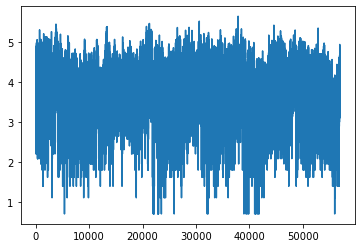

In [20]:
X_train=[]
y_train=[]
for station in tqdm(stations):
    # Reading input file
    df = pd.read_csv(f"{folder}/{station}.csv",sep=";")
    # Limiting Date
    df = df[df["DATE"]<"2020-01-01"]
    for field in fields:
        print(f"{station}: {field}")
        
        tdf = df[["DATE",field]].copy()

        #Stop is there are null values
        if (tdf[field].isnull().sum()>0):
          break

        # Log transform
        tdf[field]=np.log1p(tdf[field])

        plt.plot(tdf[field])
        plt.show()
        #STL Decomp
        #stl = seasonal_decompose(tdf[field], model="additive",period=24)

        #tdf[field]=tdf[field]-stl.seasonal
        #tdf["trend"]=stl.trend
        tdf["trend"]=0


        horizon=13

        tdf["trend_norm"]=tdf["trend"].shift(horizon)

        # We remove the trend and keep past values
        tdf[field]=tdf[field]-tdf["trend_norm"]
        for h in np.arange(0,horizon+seq_length+1):
            if h>horizon:
                temp = pd.DataFrame()
                temp[f"value - {h}"]=(tdf[field].shift(h)-tdf["trend_norm"]).copy()
                tdf=pd.concat([tdf,temp],axis=1)

        tdf=tdf.dropna()

        cols = tdf.columns[tdf.columns.str.contains(f"value -")]
        X = tdf[cols].copy()
        y = tdf[[field]].copy()
        y.columns=["values"]

        TRAIN_SPLIT = tdf[tdf["DATE"]>"2018"].index.values[0]

        X_train.append(X[X.index<=TRAIN_SPLIT].copy())
        y_train.append(y[X.index<=TRAIN_SPLIT].copy())
        
X_train=pd.concat(X_train)
y_train=pd.concat(y_train)

In [21]:
len(X_train)

39277

In [22]:
X.shape

(56796, 168)

In [23]:
X_train.shape

(39277, 168)

In [24]:
y_train

,values
194,4.007333
195,3.806662
196,3.555348
197,3.401197
198,3.555348
...,...
39466,3.912023
39467,3.583519
39468,2.708050
39469,2.302585


In [25]:
station="28079004"
df = pd.read_csv(f"/home/sebas/data/air_qual_aemet/{station}.csv",sep=";")
# Limiting Date
df = df[df["DATE"]<"2020-01-01"]

field="SPA.NO2"

tdf = df[["DATE",field]].copy()
tdf["NO2"]=np.log1p(tdf[field])

#from statsmodels.tsa.seasonal import seasonal_decompose
#stl = seasonal_decompose(tdf[field], model="additive",period=24)
#tdf[field]=tdf[field]-stl.seasonal
#tdf["trend"]=stl.trend
tdf["seasonal"]=0
tdf["trend"]=0

horizon=13

tdf["trend_norm"]=tdf["trend"].shift(horizon)

# We remove the trend and keep past values
for h in np.arange(0,horizon+seq_length+1):
    if h>horizon:
            temp = pd.DataFrame()
            temp[f"{field} - {h}"]=(tdf[field].shift(h)-tdf["trend_norm"]).copy()
            tdf=pd.concat([tdf,temp],axis=1)
tdf=tdf.dropna()

cols = tdf.columns[tdf.columns.str.contains(f"{field} -")]
X = tdf[cols].copy()
y = tdf[["NO2"]].copy()
v_recover = tdf[["trend_norm","seasonal"]]

TRAIN_SPLIT = tdf[tdf["DATE"]>"2018"].index.values[0]

X_test=X[X.index>TRAIN_SPLIT].copy()
y_test = y[X.index>TRAIN_SPLIT].copy()
v_recover_test = v_recover[X.index>TRAIN_SPLIT].copy()

In [26]:
y_test

,NO2
39471,3.583519
39472,3.401197
39473,2.833213
39474,2.564949
39475,2.397895
...,...
56985,4.454347
56986,4.543295
56987,4.532599
56988,4.290459


In [27]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = torch.FloatTensor(X_train.values).to(device)
X_test = torch.FloatTensor(X_test.values).to(device)
y_train = torch.FloatTensor(y_train.values).to(device)
y_test= torch.FloatTensor(y_test.values).to(device)

In [28]:
device

device(type='cuda')

In [29]:
# https://github.com/harryliew/COCOB-optimizer/blob/master/cocob_bp.py

import torch.optim as optim
import torch

###########################################################################
# Training Deep Networks without Learning Rates Through Coin Betting
# Paper: https://arxiv.org/abs/1705.07795
#
# NOTE: This optimizer is hardcoded to run on GPU, needs to be parametrized
###########################################################################

class COCOBBackprop(optim.Optimizer):
    
    def __init__(self, params, alpha=100, epsilon=1e-8):
        
        self._alpha = alpha
        self.epsilon = epsilon
        defaults = dict(alpha=alpha, epsilon=epsilon)
        super(COCOBBackprop, self).__init__(params, defaults)
        
    def step(self, closure=None):
        
        loss = None
        
        if closure is not None:
            loss = closure()
            
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
        
                grad = p.grad.data
                state = self.state[p]
                
                if len(state) == 0:
                    state['gradients_sum'] = torch.zeros_like(p.data).cuda().float()
                    state['grad_norm_sum'] = torch.zeros_like(p.data).cuda().float()
                    state['L'] = self.epsilon * torch.ones_like(p.data).cuda().float()
                    state['tilde_w'] = torch.zeros_like(p.data).cuda().float()
                    state['reward'] = torch.zeros_like(p.data).cuda().float()
                    
                gradients_sum = state['gradients_sum']
                grad_norm_sum = state['grad_norm_sum']
                tilde_w = state['tilde_w']
                L = state['L']
                reward = state['reward']
                
                zero = torch.cuda.FloatTensor([0.])
                
                L_update = torch.max(L, torch.abs(grad))
                gradients_sum_update = gradients_sum + grad
                grad_norm_sum_update = grad_norm_sum + torch.abs(grad)
                reward_update = torch.max(reward - grad * tilde_w, zero)
                new_w = -gradients_sum_update/(L_update * (torch.max(grad_norm_sum_update + L_update, self._alpha * L_update)))*(reward_update + L_update)
                p.data = p.data - tilde_w + new_w
                tilde_w_update = new_w
                
                state['gradients_sum'] = gradients_sum_update
                state['grad_norm_sum'] = grad_norm_sum_update
                state['L'] = L_update
                state['tilde_w'] = tilde_w_update
                state['reward'] = reward_update

        return loss


76.712890625


0it [00:00, ?it/s]

Epoch: 0 Loss: 337.1890869140625 Val Loss: 0.6848483681678772


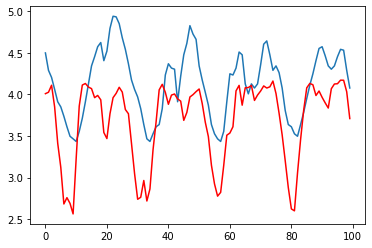

In [35]:
from sklearn.metrics import mean_squared_error

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

n_channels = 64
k_size = 3

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__() 
    self.features = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=n_channels, kernel_size=k_size, padding=1),
        nn.MaxPool1d(2),
        nn.ReLU(),
    )
    
    self.regressor = nn.Sequential(
        nn.LayerNorm(n_channels*int(seq_length/2)),
        nn.Linear(n_channels*int(seq_length/2),200),
        nn.ReLU(),
        nn.LayerNorm(200),
        nn.Linear(200,1)
    )

  def forward(self,x):
    x = self.features(x)
    #print(x.shape)
    x = x.view(-1,n_channels*x.shape[2])
    return self.regressor(x)

net = Net() 
net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = COCOBBackprop(net.parameters())
#optimizer = optim.Adam(net.parameters(),lr=0.00001,weight_decay=0.000001)

loss_arr = []
val_loss_arr = []
epochs = 1

X_train_gf = X_train.reshape(len(X_train),1,len(X_train[0]))
train = TensorDataset(X_train_gf, y_train)
train_loader = DataLoader(train, batch_size=512, shuffle=True)

print(len(X_train)/512)

for j in range(epochs):
    m_loss = []
    for i,batch in tqdm(enumerate(train_loader)):
      train_features, train_labels = batch
      y_hat = net.forward(train_features)
      loss = criterion(y_hat, train_labels)
      m_loss.append(loss.cpu().detach().numpy())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    loss_arr.append(np.mean(m_loss))

    X_test_gf = X_test.reshape(len(X_test),1,len(X_test[0]))
    predictions = net(X_test_gf).cpu().reshape(-1).detach().numpy()
    val_loss_arr.append(np.sqrt(mean_squared_error(predictions,y_test.cpu())))
    print(f'Epoch: {j} Loss: {np.mean(m_loss)} Val Loss: {np.sqrt(mean_squared_error(predictions,y_test.cpu()))}')
    
    plt.plot(y_test.cpu()[-100:])
    plt.plot(predictions[-100:],c="red")
    plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error

class GRUModel(nn.Module):
    def __init__(self):
        super(GRUModel, self).__init__()
        
        self.input_size = 1
        self.output_size=1
        self.hidden_dim=32
        self.n_layers=3

        # GRU layers
        self.gru = nn.LSTM(
            self.input_size, self.hidden_dim, self.n_layers, batch_first=True
        )

        # Fully connected layer
        self.fc = nn.Linear(self.hidden_dim, self.output_size)

    def forward(self, x):
        self.gru.flatten_parameters()
        
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

net = GRUModel() 
net.to(device)

criterion = nn.MSELoss(reduction='sum')
optimizer = COCOBBackprop(net.parameters())
#optimizer = optim.Adam(net.parameters(),lr=0.00001,weight_decay=0.000001)
batch_size = 512
epochs = 20

train = TensorDataset(X_train, y_train)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

for j in range(epochs):
    m_loss = []
    for i,batch in tqdm(enumerate(train_loader)):
        train_features, train_labels = batch
        y_hat = net.forward(train_features.reshape([len(train_features), -1, 1])).to(device)
        loss = criterion(y_hat, train_labels)
        m_loss.append(loss.detach().cpu().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    test = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)
    predictions=np.array([])
    new_ytest=np.array([])
    for i,batch in enumerate(test_loader):
        test_b = batch[0]
        predictions = np.concatenate([predictions,net(test_b.reshape([len(test_b), seq_length,1])).cpu().reshape(-1).detach().numpy()])
        new_ytest = np.concatenate([new_ytest,batch[1].cpu().detach().numpy().reshape(-1)])
    #loss_arr.append(np.mean(m_loss))
    #val_loss_arr.append(np.sqrt(mean_squared_error(predictions,y_test.cpu())))
    print(f'Epoch: {j} Loss: {np.mean(m_loss)} Val Loss: {np.sqrt(mean_squared_error(predictions,new_ytest))}')

    plt.plot(y_test.cpu()[-100:])
    plt.plot(predictions[-100:],c="red")
    plt.show()